# WWI Dataset – Exploratory Data Analysis (Python)

This notebook performs a **comprehensive exploratory data analysis (EDA)** on the provided Wide World Importers (WWI) datasets using **Python only**.

What you will get from this notebook:
- A consistent load step (handles files with a preamble row).
- Data quality checks (missingness, duplicates, types).
- Univariate + bivariate distributions (including outliers).
- Joined insights across fact + dimensions.
- Time-series views (daily/monthly trends) from the sales fact.

Files in this folder:
- `DimCity.csv`
- `DimCustomer.csv`
- `DimDate.csv`
- `DimEmployee.xlsx`
- `DimStockItem.csv`
- `FactSale.csv`

> Note: A few columns contain currency symbols/formatting; these are cleaned into numeric types for analysis.

In [1]:
from __future__ import annotations

import re
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 120)

sns.set_theme(style="whitegrid")

BASE_DIR = Path.cwd()
BASE_DIR

WindowsPath('c:/Users/NAOMI/Desktop/Portfolio/WWI')

In [2]:
# File paths
paths = {
    'DimCity': BASE_DIR / 'DimCity.csv',
    'DimCustomer': BASE_DIR / 'DimCustomer.csv',
    'DimDate': BASE_DIR / 'DimDate.csv',
    'DimEmployee': BASE_DIR / 'DimEmployee.xlsx',
    'DimStockItem': BASE_DIR / 'DimStockItem.csv',
    'FactSale': BASE_DIR / 'FactSale.csv',
}
missing = [name for name, p in paths.items() if not p.exists()]
missing

[]

In [3]:
# Load into pandas (with light cleaning)


def _read_csv_with_optional_preamble(path: Path) -> pd.DataFrame:
    """Reads a CSV that may have a title/blank preamble row before the real header.

    Some WWI dimension files start with a one-line title (e.g. 'Customer Data,,,,')
    or even a quoted comma-only line. In those cases the *second* row is the real header.
    """
    with path.open('r', encoding='utf-8', errors='replace', newline='') as f:
        first_line = f.readline().strip('\n').strip('\r')

    # Handle UTF-8 BOM and whitespace
    first_line_norm = first_line.lstrip('\ufeff').strip()
    first_line_l = first_line_norm.lower()

    # Preamble heuristics:
    # - Title row like "Customer Data,,,,"
    # - Quote/comma-only row like '",,",,,,,'
    # - Mostly separators without real headers (no 'key' token)
    looks_like_separators_only = re.fullmatch(r'["\s,]*', first_line_norm) is not None
    many_commas_no_keys = first_line_norm.count(',') >= 5 and ('key' not in first_line_l)

    has_preamble = (
        first_line_l.startswith('customer data')
        or looks_like_separators_only
        or many_commas_no_keys
    )

    df = pd.read_csv(path, skiprows=1) if has_preamble else pd.read_csv(path)

    # Normalize column names
    df.columns = [str(c).strip() for c in df.columns]
    return df


def _clean_money_or_number(s: pd.Series) -> pd.Series:
    s = s.astype(str)
    s = s.str.replace(r"\?", "", regex=True)
    s = s.str.replace(",", "", regex=False)
    s = s.str.replace(" ", "", regex=False)
    s = s.replace({"": np.nan, "-": np.nan, "nan": np.nan, "None": np.nan, "NULL": np.nan})
    return pd.to_numeric(s, errors="coerce")


df_city = pd.read_csv(paths['DimCity'])
df_city.columns = [str(c).strip() for c in df_city.columns]

# These 2 have a known preamble row
# - DimCustomer: first line 'Customer Data,,,,...'
# - DimStockItem: first line is effectively comma-only (sometimes quoted)
df_customer = _read_csv_with_optional_preamble(paths['DimCustomer'])
df_date = pd.read_csv(paths['DimDate'])
df_employee = pd.read_excel(paths['DimEmployee'])
df_stockitem = _read_csv_with_optional_preamble(paths['DimStockItem'])

df_date.columns = [str(c).strip() for c in df_date.columns]
df_employee.columns = [str(c).strip() for c in df_employee.columns]
df_stockitem.columns = [str(c).strip() for c in df_stockitem.columns]

df_sale = pd.read_csv(paths['FactSale'])
df_sale.columns = [str(c).strip() for c in df_sale.columns]

# Parse date columns
for c in ['Invoice Date Key', 'Delivery Date Key']:
    if c in df_sale.columns:
        df_sale[c] = pd.to_datetime(df_sale[c], errors='coerce')

if 'Date' in df_date.columns:
    df_date['Date'] = pd.to_datetime(df_date['Date'], errors='coerce')

# Clean money-like columns where present
for c in ['Unit Price', 'Total Excluding Tax', 'Tax Amount', 'Profit', 'Total Including Tax', 'Tax Rate']:
    if c in df_sale.columns:
        df_sale[c] = _clean_money_or_number(df_sale[c])

if 'Credit Limit' in df_customer.columns:
    df_customer['Credit Limit'] = _clean_money_or_number(df_customer['Credit Limit'])

for c in ['Unit Price', 'Recommended Retail Price', 'Typical Weight Per Unit', 'Tax Rate', 'Discount']:
    if c in df_stockitem.columns:
        df_stockitem[c] = _clean_money_or_number(df_stockitem[c])

{
    'DimCity': df_city.shape,
    'DimCustomer': df_customer.shape,
    'DimDate': df_date.shape,
    'DimEmployee': df_employee.shape,
    'DimStockItem': df_stockitem.shape,
    'FactSale': df_sale.shape,
}

c:\Users\NAOMI\AppData\Local\Programs\Python\Python314\Lib\site-packages\openpyxl\worksheet\_reader.py:223: UserWarning: Cell H2 is marked as a date but the serial value 2958466 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)
c:\Users\NAOMI\AppData\Local\Programs\Python\Python314\Lib\site-packages\openpyxl\worksheet\_reader.py:223: UserWarning: Cell H196 is marked as a date but the serial value 2958466 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)
c:\Users\NAOMI\AppData\Local\Programs\Python\Python314\Lib\site-packages\openpyxl\worksheet\_reader.py:223: UserWarning: Cell H197 is marked as a date but the serial value 2958466 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)
c:\Users\NAOMI\AppData\Local\Programs\Python\Python314\Lib\site-packages\openpyxl\worksheet\_reader.py:223: UserWarning: Cell H198 is marked as a date but the serial value 2958466 is outside the limits for dates. 

{'DimCity': (13028, 7),
 'DimCustomer': (402, 12),
 'DimDate': (1460, 14),
 'DimEmployee': (212, 9),
 'DimStockItem': (672, 21),
 'FactSale': (26397, 21)}

## Sanity check: did the tables load correctly?

This cell validates that the dimension tables have the expected headers (no `Unnamed:*` columns).
If these checks fail, the rest of the joins/EDA will be unreliable.

In [4]:
def assert_no_unnamed_columns(df: pd.DataFrame, name: str) -> None:
    bad = [c for c in df.columns if str(c).lower().startswith('unnamed')]
    if bad:
        raise ValueError(
            f"{name} still has 'Unnamed:*' columns ({bad[:8]}). "
            "This means the CSV header row wasn't read correctly. "
            "Restart the kernel and run from the top (especially the load cell)."
        )

assert_no_unnamed_columns(df_customer, 'DimCustomer')
assert_no_unnamed_columns(df_stockitem, 'DimStockItem')

print('DimCustomer columns:', list(df_customer.columns))
print('DimStockItem columns:', list(df_stockitem.columns)[:12], '...')

display(df_customer.head())
display(df_stockitem.head())

DimCustomer columns: ['Customer Key', 'WWI Customer ID', 'Customer', 'Bill To Customer', 'Category', 'Buying Group', 'Primary Contact', 'Postal Code', 'Credit Limit', 'Valid From', 'Valid To', 'Lineage Key']
DimStockItem columns: ['Stock Item Key', 'WWI Stock Item ID', 'Stock Item', 'Color', 'Selling Package', 'Buying Package', 'Brand', 'Size', 'Lead Time Days', 'Quantity Per Outer', 'Is Chiller Stock', 'Barcode'] ...


,Customer Key,WWI Customer ID,Customer,Bill To Customer,Category,Buying Group,Primary Contact,Postal Code,Credit Limit,Valid From,Valid To,Lineage Key
0,0,0,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,00:00.0,##############################################...,0
1,1,1,Tailspin Toys (Head Office),Tailspin Toys (Head Office),Novelty Shop,Tailspin Toys,Waldemar Fisar,90410.0,100000.0,00:00.0,##############################################...,2
2,2,2,"Tailspin Toys (Sylvanite, MT)",Tailspin Toys (Head Office),Novelty Shop,Tailspin Toys,Lorena Cindric,90216.0,100000.0,00:00.0,##############################################...,2
3,3,3,"Tailspin Toys (Peeples Valley, AZ)",Tailspin Toys (Head Office),Novelty Shop,Tailspin Toys,Bhaargav Rambhatla,90205.0,100000.0,00:00.0,##############################################...,2
4,4,4,"Tailspin Toys (Medicine Lodge, KS)",Tailspin Toys (Head Office),Novelty Shop,Tailspin Toys,Daniel Roman,90152.0,100000.0,00:00.0,##############################################...,2


,Stock Item Key,WWI Stock Item ID,Stock Item,Color,Selling Package,Buying Package,Brand,Size,Lead Time Days,Quantity Per Outer,Is Chiller Stock,Barcode,Tax Rate,Unit Price,Recommended Retail Price,Typical Weight Per Unit,Photo,Discount,Valid From,Valid To,Lineage Key
0,0,0,Unknown,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,0,0.0,NaN,0.00,NaN,NaN,00:00.0,##############################################...,0
1,1,219,Void fill 400 L bag (White) 400L,NaN,Each,Each,NaN,400L,14,10,0,NaN,14,50.0,74.75,1.00,NaN,NaN,00:00.0,00:00.0,5
2,2,218,Void fill 300 L bag (White) 300L,NaN,Each,Each,NaN,300L,14,10,0,NaN,14,37.5,56.06,0.75,NaN,NaN,00:00.0,00:00.0,5
3,3,217,Void fill 200 L bag (White) 200L,NaN,Each,Each,NaN,200L,14,10,0,NaN,14,25.0,37.38,0.50,NaN,NaN,00:00.0,00:00.0,5
4,4,216,Void fill 100 L bag (White) 100L,NaN,Each,Each,NaN,100L,14,10,0,NaN,14,12.5,18.69,0.25,NaN,NaN,00:00.0,00:00.0,5


In [5]:
pass

In [6]:
def profile_df(df: pd.DataFrame, name: str, top_n: int = 10) -> None:
    print(f'=== {name} ===')
    print('shape:', df.shape)
    print('columns:', list(df.columns))
    display(df.dtypes.to_frame('dtype').T)
    nulls = df.isna().sum().sort_values(ascending=False)
    display(nulls[nulls > 0].to_frame('null_count').head(top_n))

profile_df(df_city, 'DimCity')
profile_df(df_customer, 'DimCustomer')
profile_df(df_date, 'DimDate')
profile_df(df_employee, 'DimEmployee')
profile_df(df_stockitem, 'DimStockItem')
profile_df(df_sale, 'FactSale')

=== DimCity ===
shape: (13028, 7)
columns: ['City Key', 'City', 'State Province', 'Country', 'Sales Territory', 'Location', 'Latest Recorded Population']


,City Key,City,State Province,Country,Sales Territory,Location,Latest Recorded Population
dtype,int64,object,object,object,object,object,int64


,null_count


=== DimCustomer ===
shape: (402, 12)
columns: ['Customer Key', 'WWI Customer ID', 'Customer', 'Bill To Customer', 'Category', 'Buying Group', 'Primary Contact', 'Postal Code', 'Credit Limit', 'Valid From', 'Valid To', 'Lineage Key']


,Customer Key,WWI Customer ID,Customer,Bill To Customer,Category,Buying Group,Primary Contact,Postal Code,Credit Limit,Valid From,Valid To,Lineage Key
dtype,int64,int64,object,object,object,object,object,float64,float64,object,object,int64


,null_count
Bill To Customer,1
Category,1
Buying Group,1
Primary Contact,1
Postal Code,1
Credit Limit,1


=== DimDate ===
shape: (1460, 14)
columns: ['Date', 'Day Number', 'Day', 'Month', 'Short Month', 'Calendar Month Number', 'Calendar Month Label', 'Calendar Year', 'Calendar Year Label', 'Fiscal Month Number', 'Fiscal Month Label', 'Fiscal Year', 'Fiscal Year Label', 'ISO Week Number']


,Date,Day Number,Day,Month,Short Month,Calendar Month Number,Calendar Month Label,Calendar Year,Calendar Year Label,Fiscal Month Number,Fiscal Month Label,Fiscal Year,Fiscal Year Label,ISO Week Number
dtype,datetime64[ns],int64,int64,object,object,int64,object,int64,object,int64,object,int64,object,int64


,null_count


=== DimEmployee ===
shape: (212, 9)
columns: ['Employee Key', 'WWI Employee ID', 'Employee', 'Preferred Name', 'Is Salesperson', 'Photo', 'Valid From', 'Valid To', 'Lineage Key']


,Employee Key,WWI Employee ID,Employee,Preferred Name,Is Salesperson,Photo,Valid From,Valid To,Lineage Key
dtype,int64,int64,object,object,int64,float64,datetime64[ns],datetime64[ns],int64


,null_count
Photo,212
Valid To,19
Preferred Name,1


=== DimStockItem ===
shape: (672, 21)
columns: ['Stock Item Key', 'WWI Stock Item ID', 'Stock Item', 'Color', 'Selling Package', 'Buying Package', 'Brand', 'Size', 'Lead Time Days', 'Quantity Per Outer', 'Is Chiller Stock', 'Barcode', 'Tax Rate', 'Unit Price', 'Recommended Retail Price', 'Typical Weight Per Unit', 'Photo', 'Discount', 'Valid From', 'Valid To', 'Lineage Key']


,Stock Item Key,WWI Stock Item ID,Stock Item,Color,Selling Package,Buying Package,Brand,Size,Lead Time Days,Quantity Per Outer,Is Chiller Stock,Barcode,Tax Rate,Unit Price,Recommended Retail Price,Typical Weight Per Unit,Photo,Discount,Valid From,Valid To,Lineage Key
dtype,int64,int64,object,object,object,object,object,object,int64,int64,int64,float64,int64,float64,float64,float64,float64,float64,object,object,int64


,null_count
Discount,672
Photo,672
Barcode,656
Brand,605
Color,312
Size,204
Recommended Retail Price,1
Selling Package,1
Buying Package,1


=== FactSale ===
shape: (26397, 21)
columns: ['Sale Key', 'City Key', 'Customer Key', 'Bill To Customer Key', 'Stock Item Key', 'Invoice Date Key', 'Delivery Date Key', 'Salesperson Key', 'WWI Invoice ID', 'Description', 'Package', 'Quantity', 'Unit Price', 'Tax Rate', 'Total Excluding Tax', 'Tax Amount', 'Profit', 'Total Including Tax', 'Total Dry Items', 'Total Chiller Items', 'Lineage Key']


,Sale Key,City Key,Customer Key,Bill To Customer Key,Stock Item Key,Invoice Date Key,Delivery Date Key,Salesperson Key,WWI Invoice ID,Description,Package,Quantity,Unit Price,Tax Rate,Total Excluding Tax,Tax Amount,Profit,Total Including Tax,Total Dry Items,Total Chiller Items,Lineage Key
dtype,int64,int64,int64,int64,int64,datetime64[ns],datetime64[ns],int64,int64,object,object,int64,float64,int64,float64,float64,float64,float64,int64,int64,int64


,null_count
Delivery Date Key,13


## 1) Data overview & quality checks

This section:
- Builds a convenient dictionary of all tables.
- Checks shapes, duplicates, and missing values.
- Visualizes missingness to quickly see where cleaning is needed.

The goal is to understand **what we have**, **what is missing**, and **what might break joins** later.

In [7]:
# Collect tables in one place

tables = {
    'DimCity': df_city,
    'DimCustomer': df_customer,
    'DimDate': df_date,
    'DimEmployee': df_employee,
    'DimStockItem': df_stockitem,
    'FactSale': df_sale,
}

summary = []
for name, df in tables.items():
    summary.append({
        'table': name,
        'rows': df.shape[0],
        'cols': df.shape[1],
        'duplicate_rows': int(df.duplicated().sum()),
    })

pd.DataFrame(summary).sort_values('rows', ascending=False)

,table,rows,cols,duplicate_rows
5,FactSale,26397,21,0
0,DimCity,13028,7,0
2,DimDate,1460,14,0
4,DimStockItem,672,21,0
1,DimCustomer,402,12,0
3,DimEmployee,212,9,0


In [8]:
# Missingness overview (per table)

missing_summary = []
for name, df in tables.items():
    total_cells = df.shape[0] * df.shape[1]
    null_cells = int(df.isna().sum().sum())
    missing_summary.append({
        'table': name,
        'missing_cells': null_cells,
        'missing_%': (null_cells / total_cells * 100) if total_cells else 0,
    })

ms = pd.DataFrame(missing_summary).sort_values('missing_%', ascending=False)
ms

,table,missing_cells,missing_%
4,DimStockItem,3124,22.137188
3,DimEmployee,232,12.159329
1,DimCustomer,6,0.124378
5,FactSale,13,0.002345
0,DimCity,0,0.000000
2,DimDate,0,0.000000


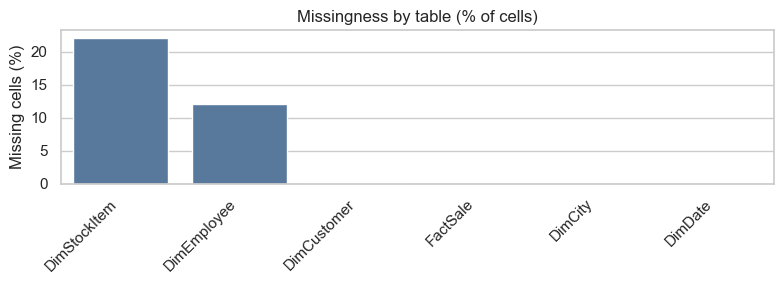

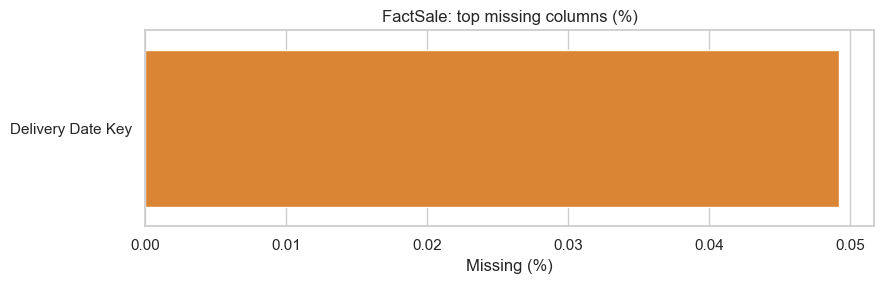

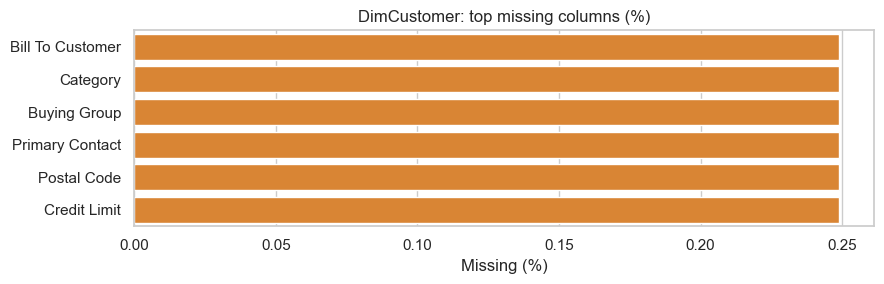

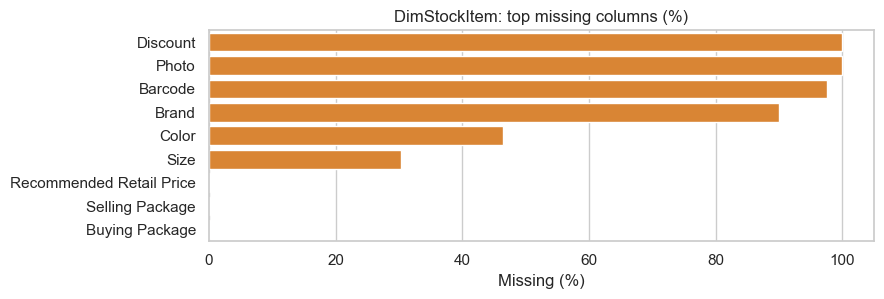

In [9]:
# Visualize missingness

plt.figure(figsize=(8, 3))
sns.barplot(data=ms, x='table', y='missing_%', color='#4C78A8')
plt.xticks(rotation=45, ha='right')
plt.title('Missingness by table (% of cells)')
plt.ylabel('Missing cells (%)')
plt.xlabel('')
plt.tight_layout()
plt.show()

# Column-level missingness for the largest table(s)

def plot_top_missing_cols(df: pd.DataFrame, name: str, top_n: int = 20) -> None:
    m = (df.isna().mean().sort_values(ascending=False) * 100)
    m = m[m > 0].head(top_n)
    if m.empty:
        print(f'{name}: no missing values detected.')
        return
    plt.figure(figsize=(9, max(3, 0.35 * len(m))))
    sns.barplot(x=m.values, y=m.index, color='#F58518')
    plt.title(f'{name}: top missing columns (%)')
    plt.xlabel('Missing (%)')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

plot_top_missing_cols(df_sale, 'FactSale')
plot_top_missing_cols(df_customer, 'DimCustomer')
plot_top_missing_cols(df_stockitem, 'DimStockItem')

## 2) Univariate analysis (distributions)

This section explores **single-table distributions** to understand:
- Typical ranges (and potential outliers)
- Skewness / heavy tails (common in sales)
- High-cardinality categorical columns (useful for grouping, but risky for modeling if unencoded)

We focus on `FactSale` first because it’s the main “signal” table.

In [10]:
# Numeric overview for FactSale

num_cols = df_sale.select_dtypes(include='number').columns.tolist()

pd.DataFrame({
    'column': num_cols,
    'missing_%': (df_sale[num_cols].isna().mean() * 100).round(2).values,
    'nunique': [df_sale[c].nunique(dropna=True) for c in num_cols],
}).sort_values(['missing_%', 'nunique'], ascending=[False, False]).head(50)

,column,missing_%,nunique
0,Sale Key,0.0,26397
6,WWI Invoice ID,0.0,8188
12,Profit,0.0,547
13,Total Including Tax,0.0,486
11,Tax Amount,0.0,483
10,Total Excluding Tax,0.0,481
4,Stock Item Key,0.0,227
1,City Key,0.0,153
5,Salesperson Key,0.0,99
8,Unit Price,0.0,62


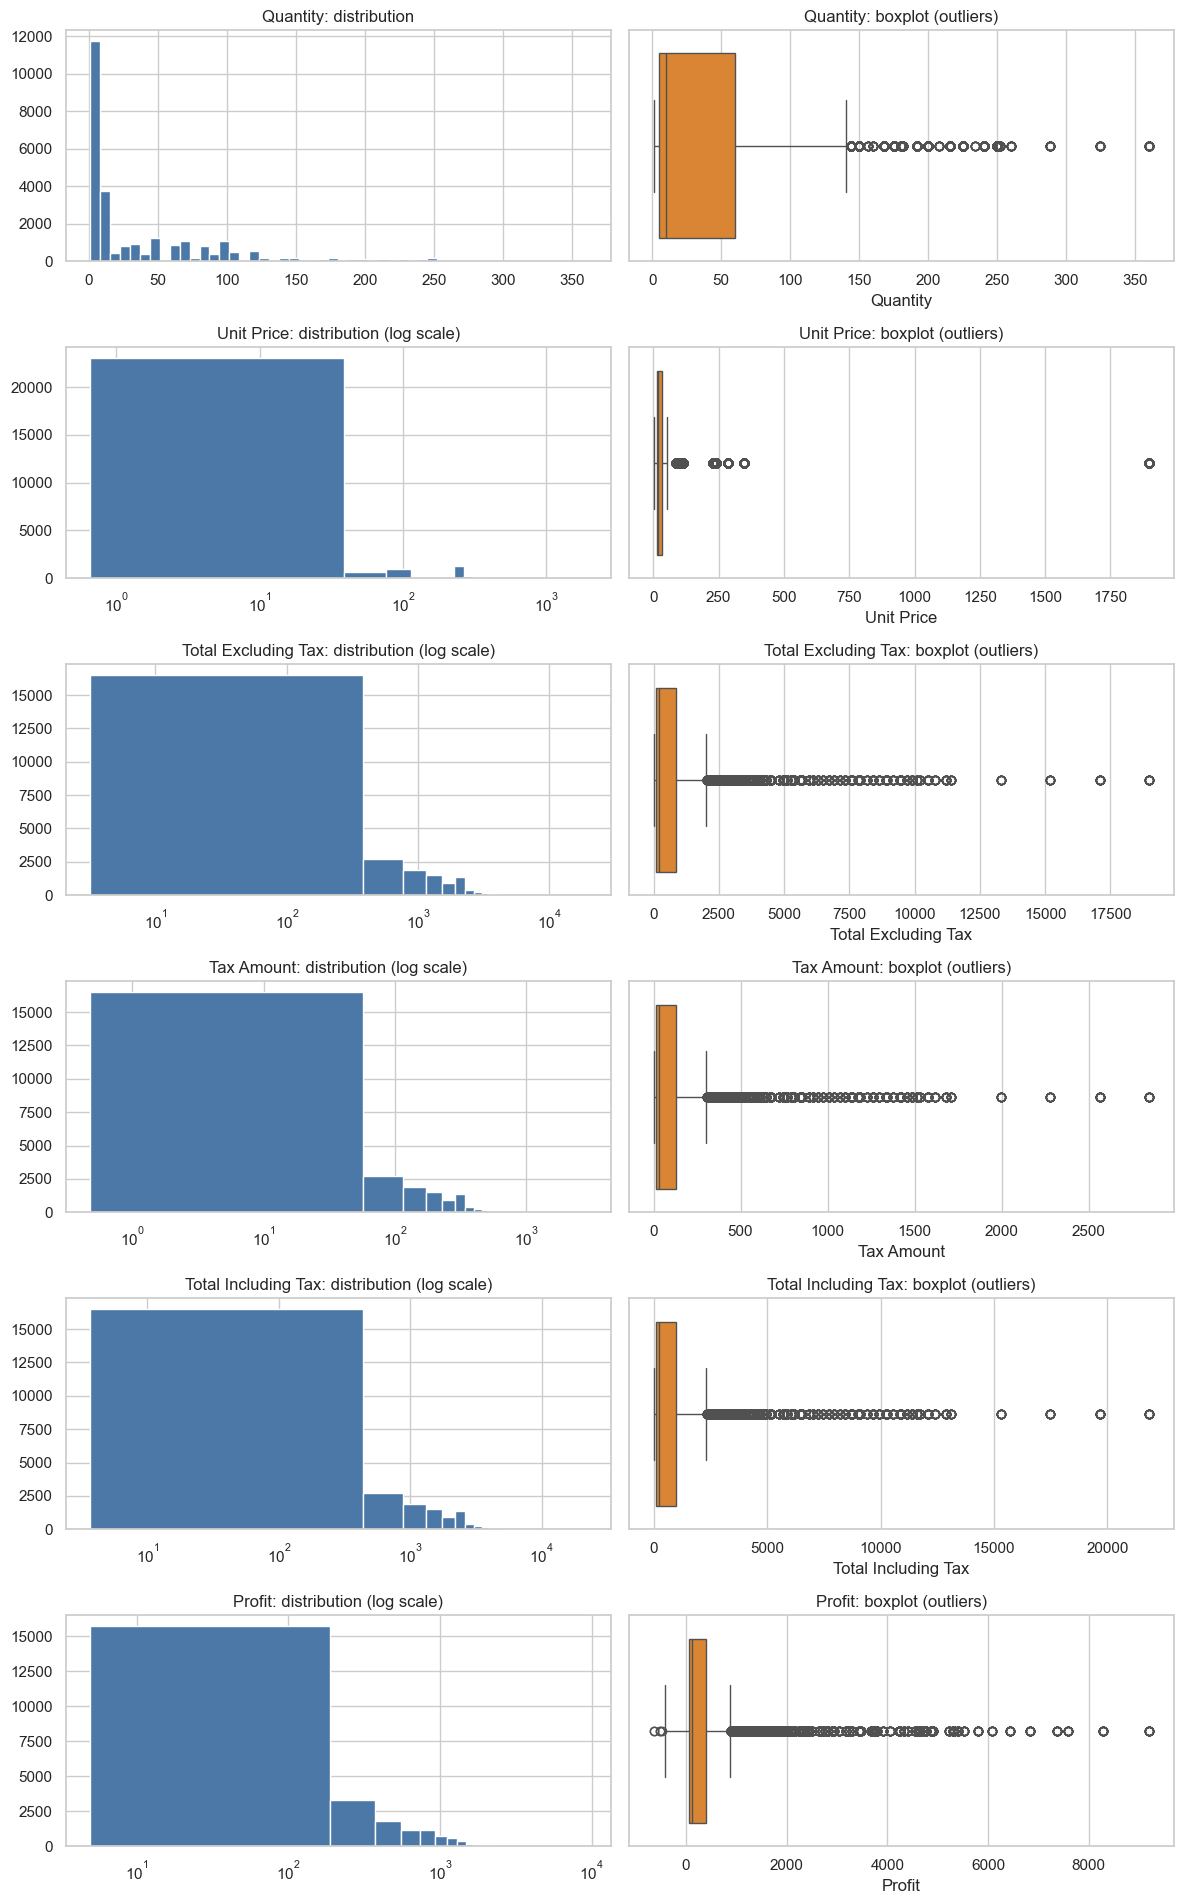

In [11]:
# Key numeric distributions (FactSale)

# Pick a few important measures if present
measure_candidates = [
    'Quantity',
    'Unit Price',
    'Total Excluding Tax',
    'Tax Amount',
    'Total Including Tax',
    'Profit',
]
measures = [c for c in measure_candidates if c in df_sale.columns]

fig, axes = plt.subplots(nrows=len(measures), ncols=2, figsize=(12, 3.2 * len(measures)))
if len(measures) == 1:
    axes = np.array([axes])

for i, c in enumerate(measures):
    x = df_sale[c].dropna()

    # Histogram (log-x for heavy-tailed measures)
    ax = axes[i, 0]
    if (x > 0).any() and x.max() / max(1e-9, x[x > 0].min()) > 1_000:
        ax.hist(x[x > 0], bins=50, color='#4C78A8')
        ax.set_xscale('log')
        ax.set_title(f'{c}: distribution (log scale)')
    else:
        ax.hist(x, bins=50, color='#4C78A8')
        ax.set_title(f'{c}: distribution')

    # Boxplot (outliers)
    ax2 = axes[i, 1]
    sns.boxplot(x=x, ax=ax2, color='#F58518')
    ax2.set_title(f'{c}: boxplot (outliers)')

plt.tight_layout()
plt.show()

## 3) Relationships & correlations (FactSale)

This section checks how numeric measures move together. Correlations help spot:
- Redundant features
- Potential leakage (e.g., a target derived from other columns)
- Strong drivers of revenue/profit

We keep it simple: Pearson correlations on numeric columns.

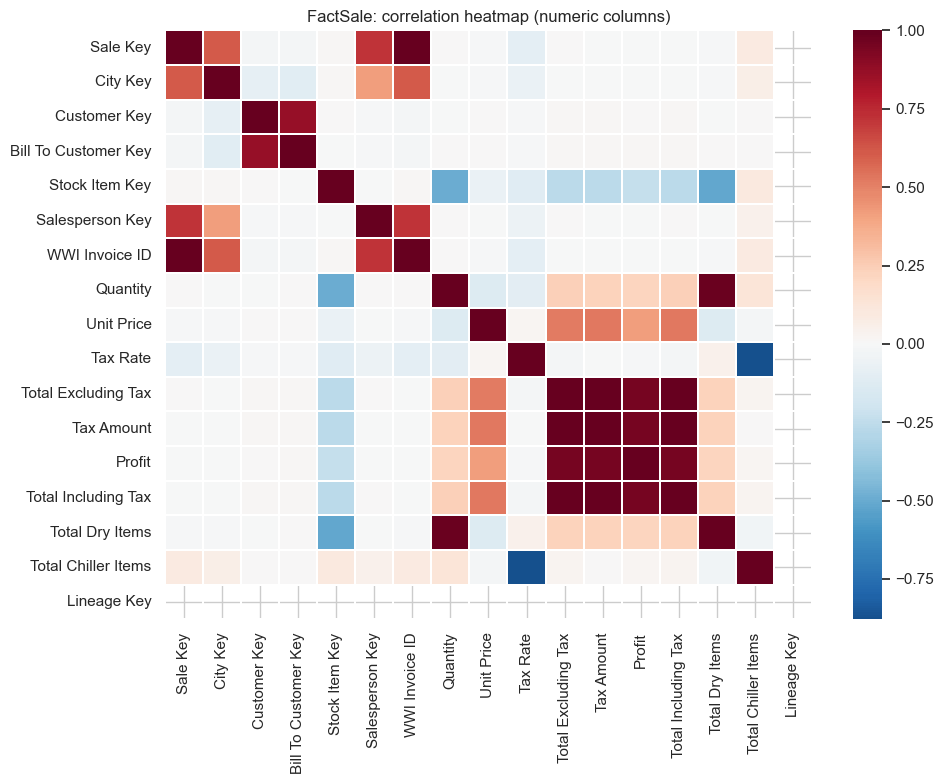

In [13]:
# Correlation heatmap (FactSale numeric columns)

sale_num = df_sale.select_dtypes(include='number').copy()

# Keep columns with enough non-null data
keep = [c for c in sale_num.columns if sale_num[c].notna().mean() > 0.8]
sale_num = sale_num[keep]

corr = sale_num.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='RdBu_r', center=0, linewidths=0.3)
plt.title('FactSale: correlation heatmap (numeric columns)')
plt.tight_layout()
plt.show()

## 4) Categorical columns & cardinality

High-cardinality categorical columns can be very informative for EDA, but they matter for modeling because they often need encoding.

Here we identify categorical columns with many unique values (especially in `FactSale`) and inspect the top categories.

In [14]:
def categorical_cardinality(df: pd.DataFrame, name: str, top_n: int = 20) -> pd.DataFrame:
    cat_cols = df.select_dtypes(exclude='number').columns
    out = []
    for c in cat_cols:
        out.append({
            'table': name,
            'column': c,
            'nunique': int(df[c].nunique(dropna=True)),
            'missing_%': float(df[c].isna().mean() * 100),
        })
    return pd.DataFrame(out).sort_values('nunique', ascending=False).head(top_n)

pd.concat([
    categorical_cardinality(df_sale, 'FactSale'),
    categorical_cardinality(df_customer, 'DimCustomer', top_n=10),
    categorical_cardinality(df_stockitem, 'DimStockItem', top_n=10),
], ignore_index=True)

,table,column,nunique,missing_%
0,FactSale,Invoice Date Key,1064,0.000000
1,FactSale,Delivery Date Key,1063,0.049248
2,FactSale,Description,227,0.000000
3,FactSale,Package,4,0.000000
4,DimCustomer,Customer,402,0.000000
5,DimCustomer,Primary Contact,401,0.248756
6,DimCustomer,Bill To Customer,2,0.248756
7,DimCustomer,Buying Group,2,0.248756
8,DimCustomer,Category,1,0.248756
9,DimCustomer,Valid From,1,0.000000


## 5) Join the fact table to dimensions (build an analysis dataset)

Most useful business insights come from combining:
- **FactSale** (measures like revenue/profit/quantity)
- **DimDate** (time attributes)
- **DimCustomer** (customer attributes)
- **DimCity** (geography)
- **DimStockItem** (product attributes)

This section creates a single `sales_enriched` dataframe for downstream EDA and (later) modeling.

In [15]:
# Build an enriched analysis dataset via left joins

sales_enriched = df_sale.copy()

# Join: city
if 'City Key' in sales_enriched.columns and 'City Key' in df_city.columns:
    city_cols = ['City Key', 'City', 'State Province', 'Country', 'Sales Territory', 'Latest Recorded Population']
    city_cols = [c for c in city_cols if c in df_city.columns]
    sales_enriched = sales_enriched.merge(df_city[city_cols], on='City Key', how='left', validate='m:1')

# Join: customer (Sold-to)
if 'Customer Key' in sales_enriched.columns and 'Customer Key' in df_customer.columns:
    cust_cols = ['Customer Key', 'Customer', 'Category', 'Buying Group', 'Postal Code', 'Credit Limit']
    cust_cols = [c for c in cust_cols if c in df_customer.columns]
    sales_enriched = sales_enriched.merge(
        df_customer[cust_cols].rename(columns={'Customer': 'Customer Name'}),
        on='Customer Key',
        how='left',
        validate='m:1',
    )

# Join: stock item
if 'Stock Item Key' in sales_enriched.columns and 'Stock Item Key' in df_stockitem.columns:
    item_cols = [
        'Stock Item Key', 'Stock Item', 'Brand', 'Color', 'Size', 'Is Chiller Stock', 'Unit Price', 'Tax Rate'
    ]
    item_cols = [c for c in item_cols if c in df_stockitem.columns]
    sales_enriched = sales_enriched.merge(
        df_stockitem[item_cols].rename(columns={'Stock Item': 'Stock Item Name'}),
        on='Stock Item Key',
        how='left',
        validate='m:1',
        suffixes=('', '_stock'),
    )

# Join: date attributes (invoice date)
if 'Invoice Date Key' in sales_enriched.columns and 'Date' in df_date.columns:
    dcols = ['Date', 'Month', 'Short Month', 'Calendar Month Number', 'Calendar Month Label', 'Calendar Year', 'ISO Week Number']
    dcols = [c for c in dcols if c in df_date.columns]
    sales_enriched = sales_enriched.merge(
        df_date[dcols].rename(columns={'Date': 'Invoice Date Key'}),
        on='Invoice Date Key',
        how='left',
        validate='m:1',
    )

# Feature helpers
if 'Total Excluding Tax' in sales_enriched.columns and 'Quantity' in sales_enriched.columns:
    sales_enriched['Revenue_per_Unit'] = sales_enriched['Total Excluding Tax'] / sales_enriched['Quantity'].replace(0, np.nan)

if 'Profit' in sales_enriched.columns and 'Total Excluding Tax' in sales_enriched.columns:
    sales_enriched['Profit_Margin'] = sales_enriched['Profit'] / sales_enriched['Total Excluding Tax'].replace(0, np.nan)

sales_enriched.shape

(26397, 46)

In [16]:
# Join quality check: how many keys failed to match?

def join_null_rate(df: pd.DataFrame, cols: list[str], label: str) -> pd.DataFrame:
    out = []
    for c in cols:
        if c in df.columns:
            out.append({'group': label, 'column': c, 'missing_%': float(df[c].isna().mean() * 100)})
    return pd.DataFrame(out).sort_values('missing_%', ascending=False)

checks = []
checks.append(join_null_rate(sales_enriched, ['City', 'Country', 'Sales Territory'], 'City join'))
checks.append(join_null_rate(sales_enriched, ['Customer Name', 'Category', 'Buying Group'], 'Customer join'))
checks.append(join_null_rate(sales_enriched, ['Stock Item Name', 'Brand', 'Is Chiller Stock'], 'Stock join'))
checks.append(join_null_rate(sales_enriched, ['Calendar Year', 'Month', 'ISO Week Number'], 'Date join'))

pd.concat(checks, ignore_index=True)

,group,column,missing_%
0,City join,City,0.000000
1,City join,Country,0.000000
2,City join,Sales Territory,0.000000
3,Customer join,Category,34.386483
4,Customer join,Buying Group,34.386483
5,Customer join,Customer Name,0.000000
6,Stock join,Brand,91.586165
7,Stock join,Stock Item Name,0.000000
8,Stock join,Is Chiller Stock,0.000000
9,Date join,Calendar Year,0.000000


## 6) Time trends (sales & profit)

This section answers:
- How does revenue and profit evolve over time?
- Are there spikes/seasonality?

We aggregate by **month** for stability (daily can be noisy).

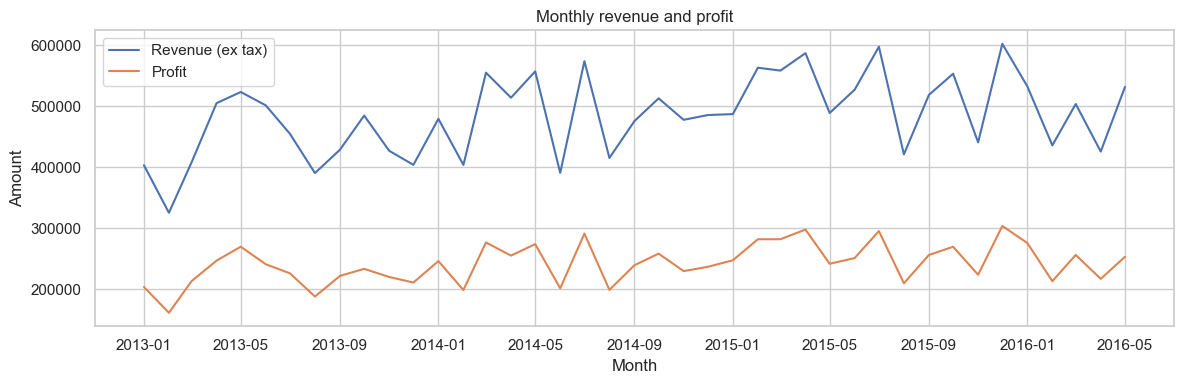

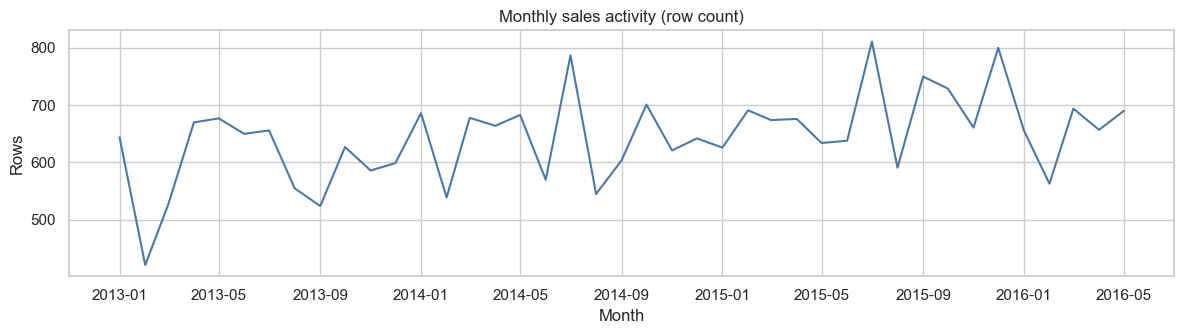

In [17]:
# Monthly revenue/profit trend

date_col = 'Invoice Date Key'

if date_col not in sales_enriched.columns or not np.issubdtype(sales_enriched[date_col].dtype, np.datetime64):
    raise ValueError("Invoice date column is missing or not parsed as datetime. Re-run the load cell.")

trend = sales_enriched.copy()
trend['InvoiceMonth'] = trend[date_col].dt.to_period('M').dt.to_timestamp()

agg = trend.groupby('InvoiceMonth', as_index=False).agg(
    revenue_ex_tax=('Total Excluding Tax', 'sum'),
    profit=('Profit', 'sum'),
    rows=('Sale Key', 'count'),
    quantity=('Quantity', 'sum'),
)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(agg['InvoiceMonth'], agg['revenue_ex_tax'], label='Revenue (ex tax)')
ax.plot(agg['InvoiceMonth'], agg['profit'], label='Profit')
ax.set_title('Monthly revenue and profit')
ax.set_xlabel('Month')
ax.set_ylabel('Amount')
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 3.5))
ax.plot(agg['InvoiceMonth'], agg['rows'], label='Sales rows', color='#4C78A8')
ax.set_title('Monthly sales activity (row count)')
ax.set_xlabel('Month')
ax.set_ylabel('Rows')
plt.tight_layout()
plt.show()

## 7) What drives revenue & profit?

We look at:
- Top customers (by revenue and by profit)
- Top products (stock items)
- Geography (country / sales territory)

Each chart is based on aggregated totals and focuses on the **top 10–15** for readability.

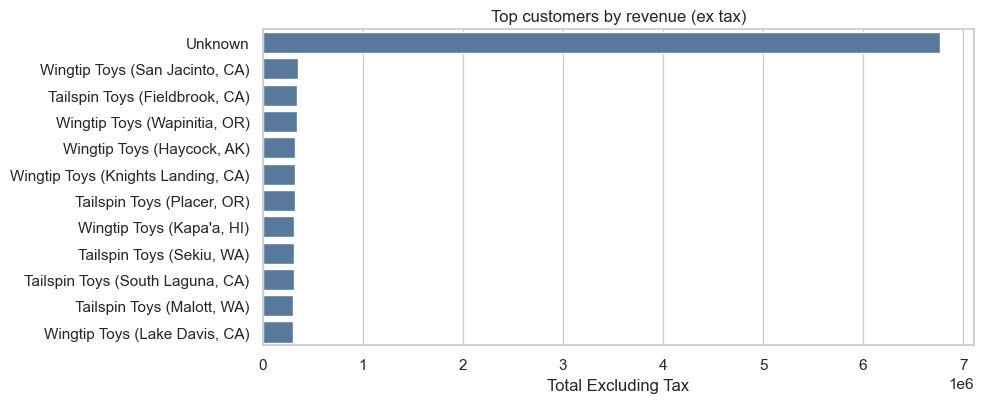

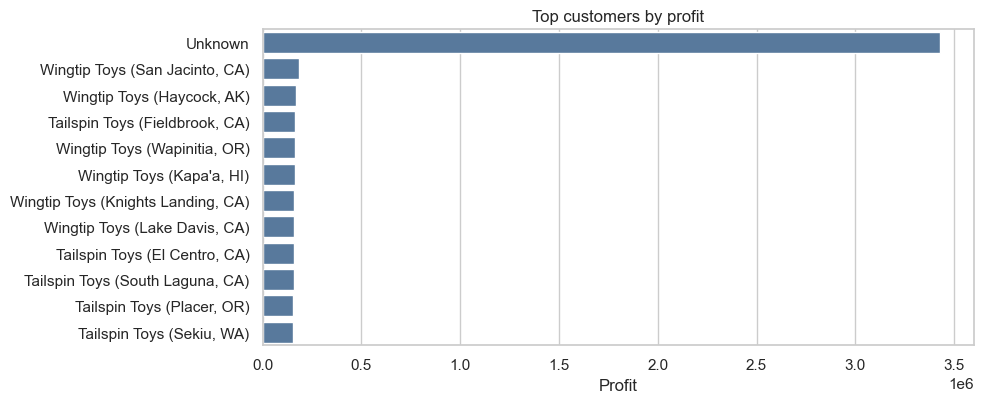

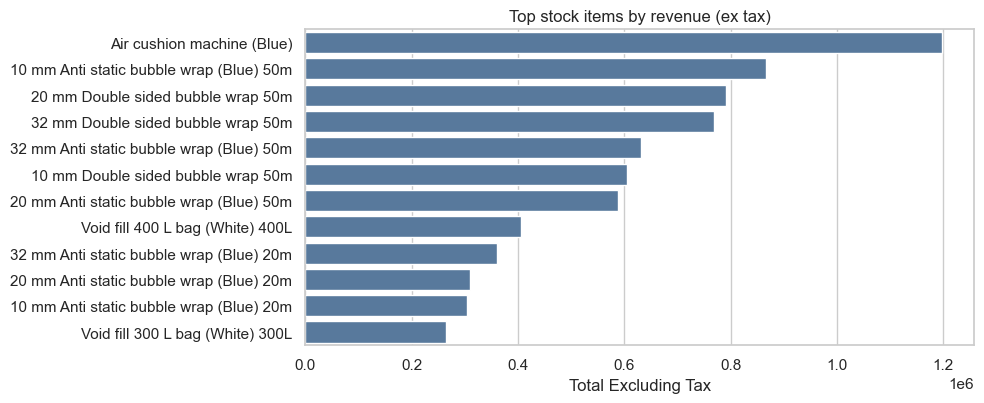

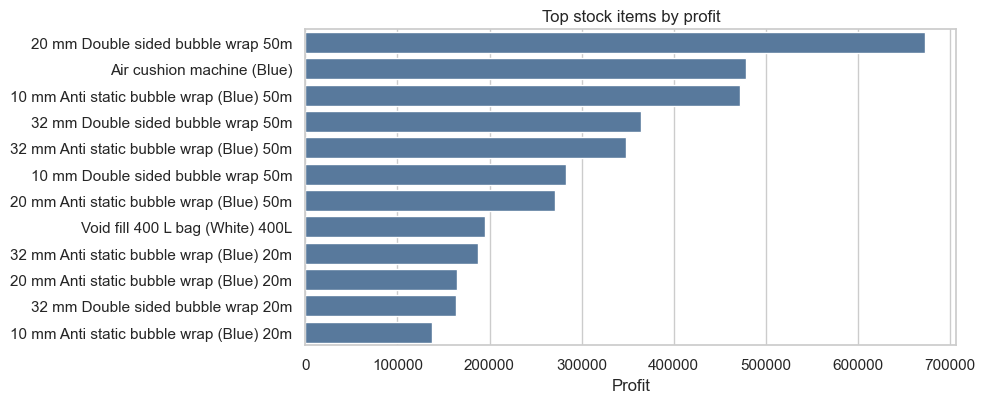

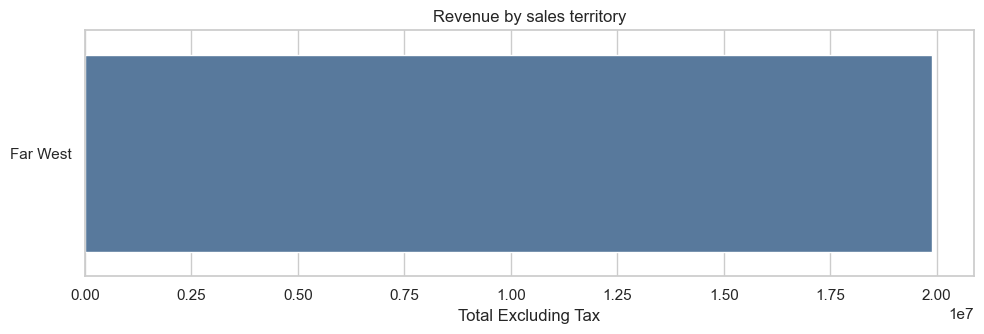

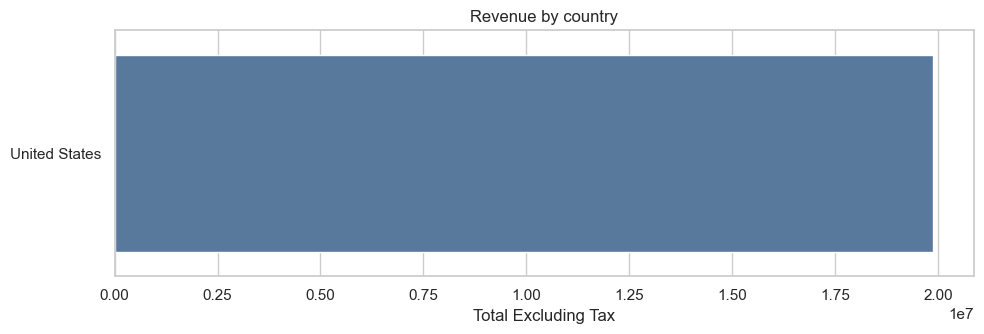

In [18]:
def plot_top(df: pd.DataFrame, group_col: str, value_col: str, title: str, n: int = 12) -> None:
    if group_col not in df.columns or value_col not in df.columns:
        print(f"Skipping {title}: missing columns")
        return

    g = (
        df.groupby(group_col, dropna=False)[value_col]
        .sum()
        .sort_values(ascending=False)
        .head(n)
        .reset_index()
    )

    plt.figure(figsize=(10, max(3.5, 0.35 * len(g))))
    sns.barplot(data=g, x=value_col, y=group_col, color='#4C78A8')
    plt.title(title)
    plt.xlabel(value_col)
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

plot_top(sales_enriched, 'Customer Name', 'Total Excluding Tax', 'Top customers by revenue (ex tax)')
plot_top(sales_enriched, 'Customer Name', 'Profit', 'Top customers by profit')

plot_top(sales_enriched, 'Stock Item Name', 'Total Excluding Tax', 'Top stock items by revenue (ex tax)')
plot_top(sales_enriched, 'Stock Item Name', 'Profit', 'Top stock items by profit')

plot_top(sales_enriched, 'Sales Territory', 'Total Excluding Tax', 'Revenue by sales territory')
plot_top(sales_enriched, 'Country', 'Total Excluding Tax', 'Revenue by country')

## 8) Profitability analysis (margins & negative-profit cases)

This section answers:
- What does the profit margin distribution look like?
- Are there **loss-making** sales rows? If yes, how common are they?

For modeling, negative or extreme margins can be very informative (discounting, returns, pricing issues), but they must be handled intentionally.

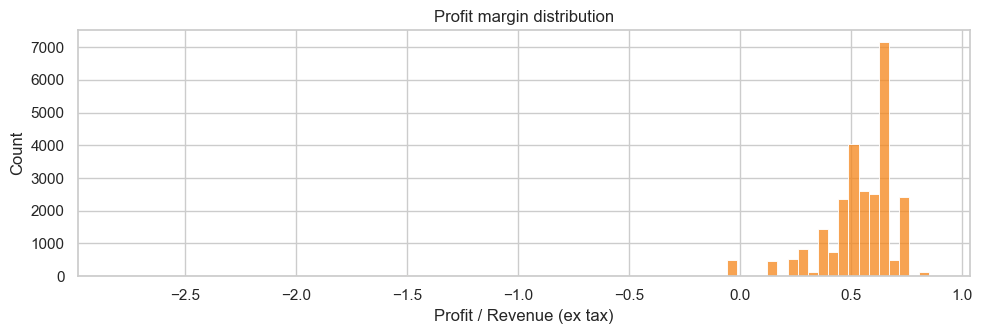

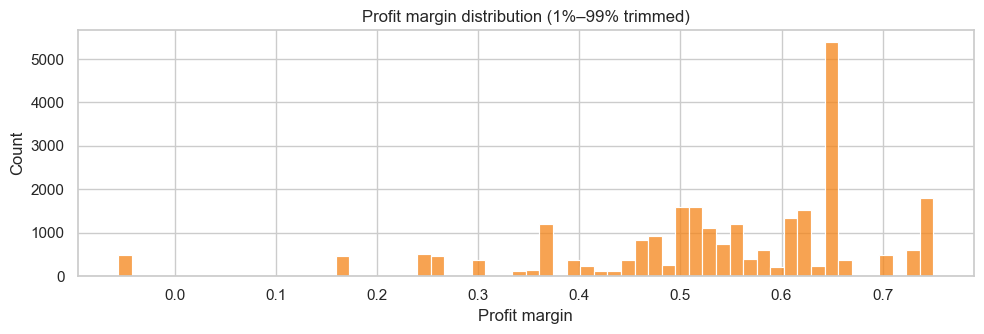

Negative-margin rows: 2.14%


In [19]:
if 'Profit_Margin' in sales_enriched.columns:
    m = sales_enriched['Profit_Margin'].replace([np.inf, -np.inf], np.nan).dropna()

    plt.figure(figsize=(10, 3.5))
    sns.histplot(m, bins=80, color='#F58518')
    plt.title('Profit margin distribution')
    plt.xlabel('Profit / Revenue (ex tax)')
    plt.tight_layout()
    plt.show()

    # Focused view (winsorized) for readability
    lo, hi = m.quantile([0.01, 0.99])
    plt.figure(figsize=(10, 3.5))
    sns.histplot(m[(m >= lo) & (m <= hi)], bins=60, color='#F58518')
    plt.title('Profit margin distribution (1%–99% trimmed)')
    plt.xlabel('Profit margin')
    plt.tight_layout()
    plt.show()

    neg_rate = float((m < 0).mean() * 100)
    print(f'Negative-margin rows: {neg_rate:.2f}%')
else:
    print('Profit_Margin not available (missing Profit and/or Total Excluding Tax).')

## 9) Customer segmentation signals

Before training a model, it’s useful to compute stable, customer-level features (RFM-style):
- **Recency**: how recently a customer purchased
- **Frequency**: how often they purchase (count of invoices/rows)
- **Monetary**: how much they spend / profit they generate

This section constructs a customer-level summary table and visualizes the distributions.

,Customer Key,last_purchase,first_purchase,rows,revenue_ex_tax,profit,qty,recency_days,Customer Name
0,0,2016-05-31,2013-01-01,9077,6768715.70,3428606.80,356472,0,Unknown
38,273,2016-05-24,2013-01-18,398,355293.35,185158.65,14870,7,"Wingtip Toys (San Jacinto, CA)"
18,102,2016-05-28,2013-01-05,405,344005.05,163720.60,17297,3,"Tailspin Toys (Fieldbrook, CA)"
40,281,2016-05-19,2013-01-23,372,343236.10,163084.60,14402,12,"Wingtip Toys (Wapinitia, OR)"
47,398,2016-05-26,2013-01-11,406,328237.65,167999.45,14640,5,"Wingtip Toys (Haycock, AK)"
46,384,2016-05-19,2013-01-11,412,327417.20,161495.30,14098,12,"Wingtip Toys (Knights Landing, CA)"
28,186,2016-05-26,2013-01-08,396,321476.10,156166.05,17120,5,"Tailspin Toys (Placer, OR)"
48,399,2016-05-26,2013-01-04,416,316857.85,161952.00,15293,5,"Wingtip Toys (Kapa'a, HI)"
16,78,2016-05-16,2013-01-16,432,314765.10,155986.45,17826,15,"Tailspin Toys (Sekiu, WA)"
20,109,2016-05-31,2013-01-05,314,314652.70,159068.00,11146,0,"Tailspin Toys (South Laguna, CA)"


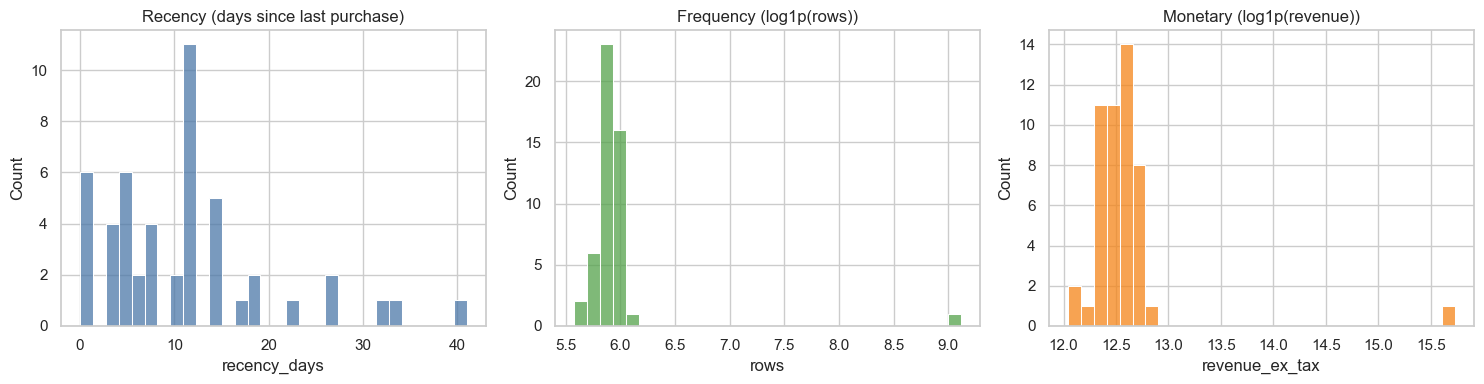

In [20]:
if 'Customer Key' in sales_enriched.columns and 'Invoice Date Key' in sales_enriched.columns:
    ref_date = sales_enriched['Invoice Date Key'].max()

    cust_agg = sales_enriched.groupby('Customer Key', as_index=False).agg(
        last_purchase=('Invoice Date Key', 'max'),
        first_purchase=('Invoice Date Key', 'min'),
        rows=('Sale Key', 'count'),
        revenue_ex_tax=('Total Excluding Tax', 'sum'),
        profit=('Profit', 'sum'),
        qty=('Quantity', 'sum'),
    )
    cust_agg['recency_days'] = (ref_date - cust_agg['last_purchase']).dt.days

    # attach names if present
    if 'Customer Key' in df_customer.columns and 'Customer' in df_customer.columns:
        cust_agg = cust_agg.merge(df_customer[['Customer Key', 'Customer']].rename(columns={'Customer': 'Customer Name'}), on='Customer Key', how='left')

    display(cust_agg.sort_values('revenue_ex_tax', ascending=False).head(10))

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    sns.histplot(cust_agg['recency_days'].dropna(), bins=30, ax=axes[0], color='#4C78A8')
    axes[0].set_title('Recency (days since last purchase)')

    sns.histplot(np.log1p(cust_agg['rows']), bins=30, ax=axes[1], color='#54A24B')
    axes[1].set_title('Frequency (log1p(rows))')

    sns.histplot(np.log1p(cust_agg['revenue_ex_tax']), bins=30, ax=axes[2], color='#F58518')
    axes[2].set_title('Monetary (log1p(revenue))')

    plt.tight_layout()
    plt.show()
else:
    print('Cannot compute customer aggregation (missing Customer Key and/or Invoice Date Key).')

## 10) Key findings & next steps for training

Use this final section to capture what you learned and decide what to do before modeling.

As you run the notebook, pay special attention to:
- **Header issues / schema correctness** (dimension tables must load with correct columns)
- **Missing joins** (nulls in dimension attributes after merging)
- **Outliers** in revenue/price/quantity
- **Negative profit margins** (if present)
- **High-cardinality text columns** (`Description`) that may require NLP/encoding or dropping

In [21]:
# Automated "EDA notes" to guide your written findings (edit/extend after reviewing charts)

notes = []

# Data quality
notes.append(f"FactSale rows: {len(df_sale):,}, columns: {df_sale.shape[1]}")
notes.append(f"Missing Delivery Date: {df_sale['Delivery Date Key'].isna().mean() * 100:.2f}%" if 'Delivery Date Key' in df_sale.columns else "Delivery Date column not found")

# Outlier hints
for c in ['Quantity', 'Unit Price', 'Total Excluding Tax', 'Profit']:
    if c in df_sale.columns:
        q99 = df_sale[c].quantile(0.99)
        notes.append(f"{c}: 99th percentile = {q99:,.2f}")

# Negative profit
if 'Profit' in df_sale.columns:
    notes.append(f"Negative-profit rows: {(df_sale['Profit'] < 0).mean() * 100:.2f}%")

pd.Series(notes, name='EDA notes')

0                 FactSale rows: 26,397, columns: 21
1                       Missing Delivery Date: 0.05%
2                 Quantity: 99th percentile = 240.00
3               Unit Price: 99th percentile = 285.00
4    Total Excluding Tax: 99th percentile = 8,400.00
5                 Profit: 99th percentile = 4,554.00
6                        Negative-profit rows: 2.14%
Name: EDA notes, dtype: object

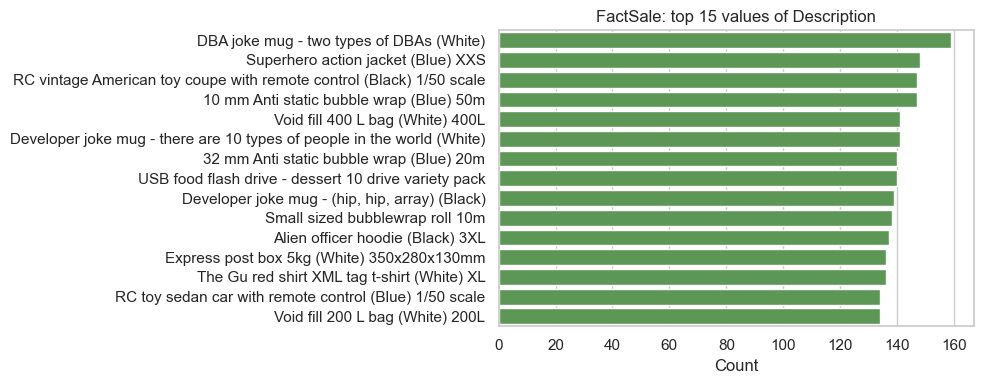

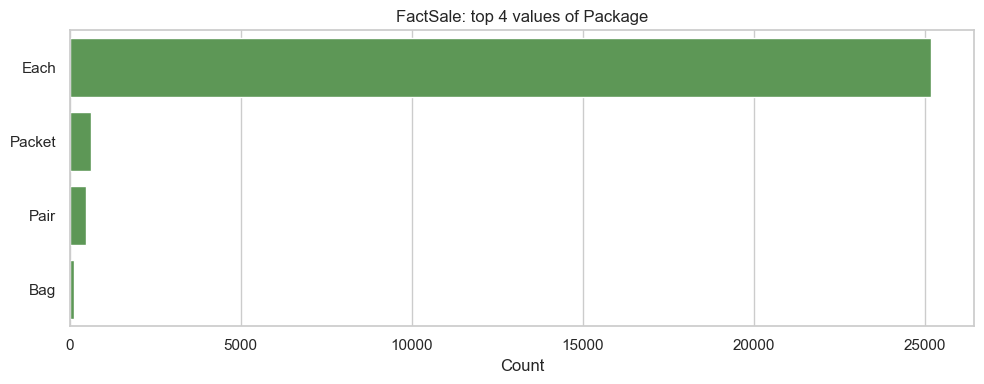

In [22]:
# Top values for a few key categorical columns (if present)

cat_candidates = ['Description', 'Package']
cat_cols = [c for c in cat_candidates if c in df_sale.columns]

for c in cat_cols:
    vc = df_sale[c].value_counts(dropna=False).head(15)
    plt.figure(figsize=(10, 4))
    sns.barplot(x=vc.values, y=vc.index, color='#54A24B')
    plt.title(f'FactSale: top {len(vc)} values of {c}')
    plt.xlabel('Count')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

# Data Cleaning & Preparation for Training

This section prepares a **model-ready dataset** using modern data science practices.

Principles:
- Keep raw data intact; create new cleaned copies.
- Make each step **reproducible**.
- Avoid data leakage (especially around dates and targets).
- Use **train/validation splits** that reflect real-world usage (time-based split for sales).

We will:
- Validate schema + duplicates
- Handle missing values and types
- Create a clean `model_df` derived from `sales_enriched`
- Create a time-based split (`train_df`, `valid_df`)
- Build a scikit-learn `ColumnTransformer` preprocessing pipeline


## 1) Define the modeling target and feature set

We need to decide what we are training *for* (the **target**).

Common supervised targets for this dataset:
- `Profit` (regression)
- `Total Excluding Tax` (revenue regression)
- `Quantity` (demand regression)

Below we set a default target and define a list of columns that should be excluded to avoid leakage (IDs, free-text descriptions, and columns that directly derive the target).

You can change `TARGET` later without changing the rest of the pipeline.

In [23]:
# Choose a target
# You can change this later (e.g. to 'Total Excluding Tax' or 'Quantity')
TARGET = 'Profit'

assert 'sales_enriched' in globals(), "Run the EDA join section first so sales_enriched exists"
assert TARGET in sales_enriched.columns, f"Target '{TARGET}' not found in sales_enriched"

# Columns that should generally NOT be used as features for training
# - Identifiers (high-cardinality keys)
# - Free text that would need separate NLP work
# - Columns that are direct components of other measures (potential leakage depending on target)
EXCLUDE_COLS = {
    'Sale Key',
    'WWI Invoice ID',
    'Lineage Key',
    'Description',
    'Package',
}

# If predicting Profit, avoid using the Profit itself, and optionally avoid using Total Including Tax
# (You may decide to include revenue measures depending on your modeling goal.)
if TARGET == 'Profit':
    EXCLUDE_COLS.update({'Profit'})

# Base time column (needed for time split)
TIME_COL = 'Invoice Date Key'
assert TIME_COL in sales_enriched.columns, f"Expected '{TIME_COL}' for time-based splitting"

# Make a working copy
work = sales_enriched.copy()

# Keep only rows with known target and known time
work = work.loc[work[TARGET].notna() & work[TIME_COL].notna()].copy()

work.shape

(26397, 46)

## 2) Data quality checks (duplicates, impossible values)

This block performs quick checks that are usually mandatory before training:
- Duplicate rows
- Duplicate primary keys (if present)
- Basic sanity checks for numeric columns (e.g. negative quantity)

The goal is to **detect** issues and decide whether to drop/fix them, rather than silently proceeding.

In [24]:
# Duplicate row check
n_dupes = int(work.duplicated().sum())
print('Duplicate rows:', n_dupes)

# Key uniqueness checks (if keys exist)
for key_col in ['Sale Key']:
    if key_col in sales_enriched.columns:
        dup_keys = int(sales_enriched[key_col].duplicated().sum())
        print(f'Duplicate {key_col}:', dup_keys)

# Basic numeric sanity checks
if 'Quantity' in work.columns:
    print('Negative Quantity rows:', int((work['Quantity'] < 0).sum()))

if 'Total Excluding Tax' in work.columns:
    print('Negative Revenue rows:', int((work['Total Excluding Tax'] < 0).sum()))

if 'Profit' in sales_enriched.columns:
    print('Negative Profit rows:', int((sales_enriched['Profit'] < 0).sum()))

Duplicate rows: 0
Duplicate Sale Key: 0
Negative Quantity rows: 0
Negative Revenue rows: 0
Negative Profit rows: 566


## 3) Standardize types and clean obvious placeholders

Modern practice is to:
- Ensure datetimes are `datetime64[ns]`
- Ensure numeric columns are numeric
- Replace placeholder strings with proper missing values

We only do *safe* cleaning here (no target leakage, no heavy transformations yet).

In [25]:
# Replace common placeholder strings with NaN (only in object columns)
placeholders = {
    'N/A': np.nan,
    'NA': np.nan,
    'None': np.nan,
    'NULL': np.nan,
    '': np.nan,
}

obj_cols = work.select_dtypes(include='object').columns
work[obj_cols] = work[obj_cols].replace(placeholders)

# Ensure time col is datetime
work[TIME_COL] = pd.to_datetime(work[TIME_COL], errors='coerce')

# Coerce a few common numeric columns if present
for c in ['Quantity', 'Unit Price', 'Tax Rate', 'Total Excluding Tax', 'Tax Amount', 'Total Including Tax', 'Profit', 'Revenue_per_Unit', 'Profit_Margin']:
    if c in work.columns:
        work[c] = pd.to_numeric(work[c], errors='coerce')

work.dtypes.head(20)

Sale Key                         int64
City Key                         int64
Customer Key                     int64
Bill To Customer Key             int64
Stock Item Key                   int64
Invoice Date Key        datetime64[ns]
Delivery Date Key       datetime64[ns]
Salesperson Key                  int64
WWI Invoice ID                   int64
Description                     object
Package                         object
Quantity                         int64
Unit Price                     float64
Tax Rate                         int64
Total Excluding Tax            float64
Tax Amount                     float64
Profit                         float64
Total Including Tax            float64
Total Dry Items                  int64
Total Chiller Items              int64
dtype: object

## 4) Define a clean feature matrix (`X`) and target (`y`)

We now:
- Drop excluded columns
- Separate target `y`
- Keep only columns that are valid for modeling

We keep this step explicit so you can easily audit what goes into the model.

In [26]:
# Define feature columns
feature_cols = [c for c in work.columns if c not in EXCLUDE_COLS and c != TARGET]

# Drop high-leakage columns depending on target choice
# If predicting Profit, you usually should not include direct totals derived from profit components.
# Keep this conservative by default.
if TARGET == 'Profit':
    for leak_col in ['Total Including Tax']:
        if leak_col in feature_cols:
            feature_cols.remove(leak_col)

X = work[feature_cols].copy()
y = work[TARGET].copy()

print('X shape:', X.shape)
print('y shape:', y.shape)
print('Example feature columns:', feature_cols[:25])

X shape: (26397, 39)
y shape: (26397,)
Example feature columns: ['City Key', 'Customer Key', 'Bill To Customer Key', 'Stock Item Key', 'Invoice Date Key', 'Delivery Date Key', 'Salesperson Key', 'Quantity', 'Unit Price', 'Tax Rate', 'Total Excluding Tax', 'Tax Amount', 'Total Dry Items', 'Total Chiller Items', 'City', 'State Province', 'Country', 'Sales Territory', 'Latest Recorded Population', 'Customer Name', 'Category', 'Buying Group', 'Postal Code', 'Credit Limit', 'Stock Item Name']


## 5) Train/validation split (time-based)

For transactional/time-series-like business data, a random split can leak future information.

Here we split by time:
- Train = older data
- Validation = most recent `VALID_FRACTION`

This mimics how the model will be used in production: predicting on future data.

In [27]:
VALID_FRACTION = 0.2

# Sort by time
order = work[TIME_COL].sort_values()
cutoff = order.iloc[int(len(order) * (1 - VALID_FRACTION))]

train_mask = work[TIME_COL] < cutoff

X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_valid, y_valid = X.loc[~train_mask], y.loc[~train_mask]

print('Cutoff date:', cutoff)
print('Train rows:', len(X_train), 'Valid rows:', len(X_valid))

# Ensure split is time-ordered
print('Train max date:', work.loc[train_mask, TIME_COL].max())
print('Valid min date:', work.loc[~train_mask, TIME_COL].min())

Cutoff date: 2015-10-08 00:00:00
Train rows: 21090 Valid rows: 5307
Train max date: 2015-10-07 00:00:00
Valid min date: 2015-10-08 00:00:00


## 6) Preprocessing pipeline (imputation + encoding)

Modern ML practice is to put preprocessing into a **single pipeline** so it can be:
- Fit on training data only
- Applied identically to validation/test
- Saved and reused later

We will:
- Impute numeric features with median
- Impute categorical features with most-frequent
- One-hot encode categorical features

(Scaling is optional; tree models do not need it. We’ll skip scaling by default.)

In [32]:
!pip install sci-kit learn

  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for learn: filename=learn-1.0.0-py3-none-any.whl size=1262 sha256=9f21d4da69e7373e3abf0e4c649ee88fda43d5ba8b97302479af1606d25a8345
  Stored in directory: c:\users\naomi\appdata\local\pip\cache\wheels\06\0e\4c\1806fef063146786f7b9da15347813b4e41537f9059f7251c0
Successfully built learn

   ---------------------------------------- 0/2 [learn]
   -------------------- ------------------- 1/2 [sci-kit]
   -------------------- ------------------- 1/2 [sci-kit]
   ---------------------------------------- 2/2 [sci-kit]



In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

num_features = X_train.select_dtypes(include='number').columns.tolist()
cat_features = [c for c in X_train.columns if c not in num_features]

numeric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, num_features),
        ('cat', categorical_pipe, cat_features),
    ],
    remainder='drop',
)

# Fit on train only
X_train_p = preprocess.fit_transform(X_train)
X_valid_p = preprocess.transform(X_valid)

print('Processed train shape:', X_train_p.shape)
print('Processed valid shape:', X_valid_p.shape)

Processed train shape: (21090, 2208)
Processed valid shape: (5307, 2208)


## 7) Outlier handling (optional)

Tree models and linear models can be sensitive to extreme values depending on the objective.
Here we optionally cap numeric features using quantiles computed on the training set.

> If you plan to use tree-based models only, you may skip this section.

In [34]:
# Optional: cap numeric feature outliers on the *raw* (pre-encoded) feature frame
# This is applied before the preprocessing pipeline.

CAP_OUTLIERS = True
LOW_Q = 0.01
HIGH_Q = 0.99

if CAP_OUTLIERS:
    X_train_c = X_train.copy()
    X_valid_c = X_valid.copy()

    caps = {}
    for c in num_features:
        lo = X_train_c[c].quantile(LOW_Q)
        hi = X_train_c[c].quantile(HIGH_Q)
        caps[c] = (lo, hi)
        X_train_c[c] = X_train_c[c].clip(lower=lo, upper=hi)
        X_valid_c[c] = X_valid_c[c].clip(lower=lo, upper=hi)

    # Re-fit preprocess after capping
    X_train_p = preprocess.fit_transform(X_train_c)
    X_valid_p = preprocess.transform(X_valid_c)

    print('Applied outlier caps to numeric features.')
    print('Processed train shape:', X_train_p.shape)
    print('Processed valid shape:', X_valid_p.shape)
else:
    print('CAP_OUTLIERS is False; using previous X_train_p/X_valid_p.')

Applied outlier caps to numeric features.
Processed train shape: (21090, 2208)
Processed valid shape: (5307, 2208)


## 8) Export prepared matrices (optional)

If you want to reuse the prepared matrices outside the notebook, you can export them.
Common formats:
- `npz` for dense numpy arrays
- `parquet` if you convert to a DataFrame

> Note: If the one-hot output is large, consider using sparse output (`OneHotEncoder(..., sparse_output=True)`).

In [35]:
# Optional exports

EXPORT = False

if EXPORT:
    import numpy as np

    np.savez_compressed(
        BASE_DIR / 'wwi_prepared_matrices.npz',
        X_train=X_train_p,
        X_valid=X_valid_p,
        y_train=y_train.to_numpy(),
        y_valid=y_valid.to_numpy(),
    )
    print('Exported to wwi_prepared_matrices.npz')
else:
    print('EXPORT is False; skipping write.')

EXPORT is False; skipping write.


## 9) Baseline model (auto: regression vs classification)

This section trains a simple baseline using the prepared preprocessing step and evaluates it on the validation split.

- If the target looks continuous: **Ridge regression**
- If the target looks categorical / low-cardinality: **Logistic regression**

In [37]:
import numpy as np

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

# Expect these to exist from earlier section:
# - X_train_p, X_valid_p
# - y_train, y_valid


def _is_classification_target(y: pd.Series) -> bool:
    # Heuristic: object/bool/category, or small number of unique values
    if hasattr(y, 'dtype') and (str(y.dtype) in {'object', 'bool', 'category'}):
        return True
    # numeric but low-cardinality -> treat as classification
    nunique = int(pd.Series(y).nunique(dropna=True))
    return nunique <= 20


y_train_s = pd.Series(y_train)
y_valid_s = pd.Series(y_valid)

if _is_classification_target(y_train_s):
    # Classification baseline
    clf = LogisticRegression(max_iter=2000)
    clf.fit(X_train_p, y_train_s)

    pred = clf.predict(X_valid_p)

    acc = accuracy_score(y_valid_s, pred)
    f1 = f1_score(y_valid_s, pred, average='weighted')

    print('Task: classification')
    print('Accuracy:', round(float(acc), 4))
    print('F1 (weighted):', round(float(f1), 4))
    print('Confusion matrix:')
    print(confusion_matrix(y_valid_s, pred))
    print('\nClassification report:')
    print(classification_report(y_valid_s, pred))
else:
    # Regression baseline
    reg = Ridge(alpha=1.0, random_state=0)
    reg.fit(X_train_p, y_train_s)

    pred = reg.predict(X_valid_p)

    mse = mean_squared_error(y_valid_s, pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_valid_s, pred)
    r2 = r2_score(y_valid_s, pred)

    print('Task: regression')
    print('RMSE:', round(rmse, 4))
    print('MAE :', round(float(mae), 4))
    print('R²  :', round(float(r2), 4))

Task: regression
RMSE: 169.638
MAE : 62.8335
R²  : 0.9512


## 10) Forecasting (time-series) – predict future monthly revenue/profit

In this section we **forecast future months** using the historical sales fact.

**Approach (simple + explainable):**
- Aggregate sales to **monthly totals** (revenue and profit).
- Build **time features** (month number) + **lag features** (previous months).
- Train a regression model on the past and validate on the most recent months.
- Fit on all history and **forecast the next `FORECAST_HORIZON` months**.

> This is a baseline forecasting approach (feature-based regression). It’s often strong enough for portfolio projects and is easy to explain.

In [38]:
# Build a clean monthly time series from the enriched sales table

if 'sales_enriched' not in globals():
    raise NameError("sales_enriched is not defined. Run the earlier join cell that creates sales_enriched.")

if 'Invoice Date Key' not in sales_enriched.columns:
    raise KeyError("Expected 'Invoice Date Key' in sales_enriched.")

if not np.issubdtype(sales_enriched['Invoice Date Key'].dtype, np.datetime64):
    raise TypeError("'Invoice Date Key' must be datetime. Re-run the load cell that parses dates.")

# Monthly aggregation (month start timestamp)
ts = sales_enriched.copy()
ts['InvoiceMonth'] = ts['Invoice Date Key'].dt.to_period('M').dt.to_timestamp()

monthly = (
    ts.groupby('InvoiceMonth', as_index=False)
      .agg(
          revenue_ex_tax=('Total Excluding Tax', 'sum'),
          profit=('Profit', 'sum'),
          rows=('Sale Key', 'count'),
          quantity=('Quantity', 'sum'),
      )
      .sort_values('InvoiceMonth')
)

monthly.head()

,InvoiceMonth,revenue_ex_tax,profit,rows,quantity
0,2013-01-01,403488.60,203821.60,644,22223
1,2013-02-01,325488.30,161465.60,421,16749
2,2013-03-01,407959.15,213303.75,527,20440
3,2013-04-01,505192.20,246955.85,670,25354
4,2013-05-01,523554.05,269845.35,677,27148


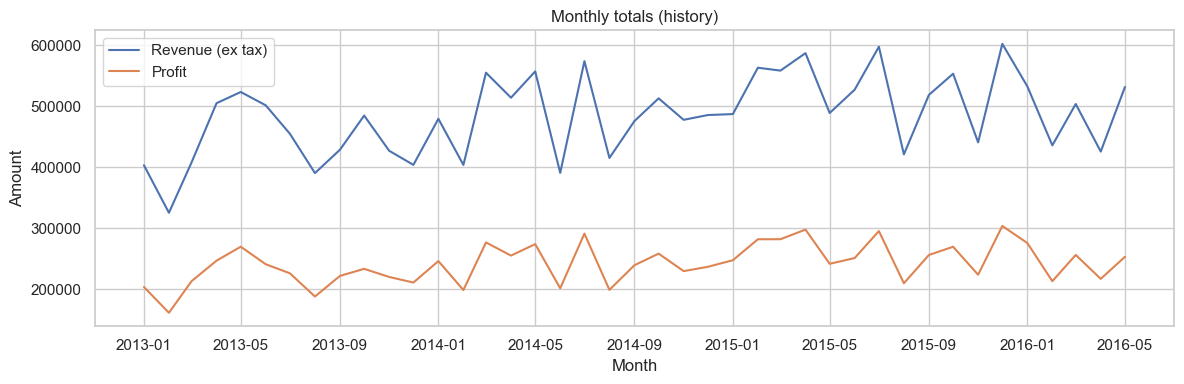

In [39]:
# Quick visualization of the monthly series

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(monthly['InvoiceMonth'], monthly['revenue_ex_tax'], label='Revenue (ex tax)')
ax.plot(monthly['InvoiceMonth'], monthly['profit'], label='Profit')
ax.set_title('Monthly totals (history)')
ax.set_xlabel('Month')
ax.set_ylabel('Amount')
ax.legend()
plt.tight_layout()
plt.show()

### Feature engineering for forecasting

Because this is time-series data, we avoid random shuffling.

We create features that use **only past information**:
- **Calendar features**: month number (seasonality)
- **Lag features**: previous 1, 2, 3, 6, 12 months of the target
- **Rolling mean**: average of the last 3 months

We then do a simple backtest:
- Train on early months
- Validate on the most recent `N_VALID_MONTHS` months

This gives an honest estimate of how the model may perform on future months.

Forecast target: revenue_ex_tax
Train months: 23  Valid months: 6
Validation RMSE: 99714.6
Validation MAE : 88470.76


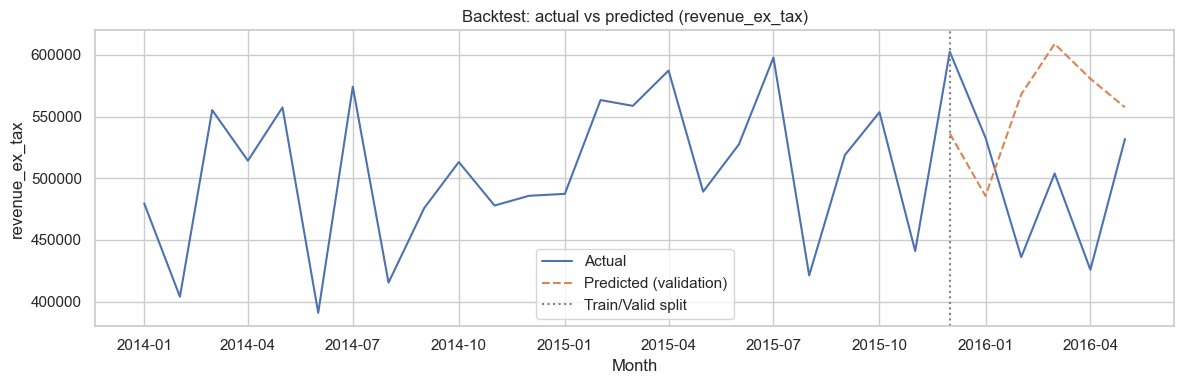

In [40]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

TARGET_COL = 'revenue_ex_tax'  # change to 'profit' if you want to forecast profit instead
FORECAST_HORIZON = 6           # months ahead to predict
N_VALID_MONTHS = 6             # holdout window for backtest


def make_ts_features(df: pd.DataFrame, target_col: str) -> pd.DataFrame:
    out = df.copy()
    out = out.sort_values('InvoiceMonth')

    out['month_num'] = out['InvoiceMonth'].dt.month

    for lag in [1, 2, 3, 6, 12]:
        out[f'{target_col}_lag_{lag}'] = out[target_col].shift(lag)

    out[f'{target_col}_roll3_mean'] = out[target_col].shift(1).rolling(3).mean()

    return out

feat_df = make_ts_features(monthly, TARGET_COL).dropna().reset_index(drop=True)

feature_cols = [c for c in feat_df.columns if c not in ['InvoiceMonth', 'revenue_ex_tax', 'profit', 'rows', 'quantity']]

X_all = feat_df[feature_cols]
y_all = feat_df[TARGET_COL]

# Time-based split (last N months as validation)
split_idx = max(1, len(feat_df) - N_VALID_MONTHS)
X_tr, X_va = X_all.iloc[:split_idx], X_all.iloc[split_idx:]
y_tr, y_va = y_all.iloc[:split_idx], y_all.iloc[split_idx:]

model = Ridge(alpha=1.0, random_state=0)
model.fit(X_tr, y_tr)

pred_va = model.predict(X_va)

rmse = float(np.sqrt(mean_squared_error(y_va, pred_va)))
mae = float(mean_absolute_error(y_va, pred_va))

print('Forecast target:', TARGET_COL)
print('Train months:', len(X_tr), ' Valid months:', len(X_va))
print('Validation RMSE:', round(rmse, 2))
print('Validation MAE :', round(mae, 2))

# Plot backtest: actual vs predicted on validation window
plot_df = feat_df[['InvoiceMonth', TARGET_COL]].copy()
plot_df['pred'] = np.nan
plot_df.loc[plot_df.index[split_idx:], 'pred'] = pred_va

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(plot_df['InvoiceMonth'], plot_df[TARGET_COL], label='Actual')
ax.plot(plot_df['InvoiceMonth'], plot_df['pred'], label='Predicted (validation)', linestyle='--')
ax.axvline(plot_df['InvoiceMonth'].iloc[split_idx], color='gray', linestyle=':', label='Train/Valid split')
ax.set_title(f'Backtest: actual vs predicted ({TARGET_COL})')
ax.set_xlabel('Month')
ax.set_ylabel(TARGET_COL)
ax.legend()
plt.tight_layout()
plt.show()

### Forecast the next months (recursive)

To forecast beyond the last observed month, we predict **one month ahead**, append it to the series, then recompute lag/rolling features and repeat.

This is called **recursive forecasting**. It’s simple, but it can accumulate error the farther you forecast.

We will:
- Refit the model on **all available history**
- Generate predictions for the next `FORECAST_HORIZON` months
- Visualize the historical series plus the forecast

In [41]:
# Refit on all available feature rows
model_full = Ridge(alpha=1.0, random_state=0)
model_full.fit(X_all, y_all)

# Work on a copy we can extend
future_monthly = monthly[['InvoiceMonth', TARGET_COL]].copy().sort_values('InvoiceMonth').reset_index(drop=True)

future_preds = []
last_month = future_monthly['InvoiceMonth'].max()

for step in range(FORECAST_HORIZON):
    next_month = (last_month + pd.offsets.MonthBegin(1))

    # Create a one-row frame for the next month with placeholder target
    tmp = pd.concat(
        [future_monthly, pd.DataFrame({'InvoiceMonth': [next_month], TARGET_COL: [np.nan]})],
        ignore_index=True,
    )

    tmp_feat = make_ts_features(tmp.rename(columns={TARGET_COL: TARGET_COL}), TARGET_COL)

    # Take the last row features (for the next month)
    last_row = tmp_feat.iloc[[-1]].copy()

    # Feature columns must match training
    X_next = last_row[feature_cols]

    y_next = float(model_full.predict(X_next)[0])

    future_preds.append({'InvoiceMonth': next_month, f'{TARGET_COL}_forecast': y_next})

    # Append prediction into the series for subsequent lags
    future_monthly = pd.concat(
        [future_monthly, pd.DataFrame({'InvoiceMonth': [next_month], TARGET_COL: [y_next]})],
        ignore_index=True,
    )

    last_month = next_month

forecast_df = pd.DataFrame(future_preds)
forecast_df

,InvoiceMonth,revenue_ex_tax_forecast
0,2016-06-01,509643.901556
1,2016-07-01,529192.788392
2,2016-08-01,480767.625707
3,2016-09-01,525021.180611
4,2016-10-01,506367.046877
5,2016-11-01,499205.016669


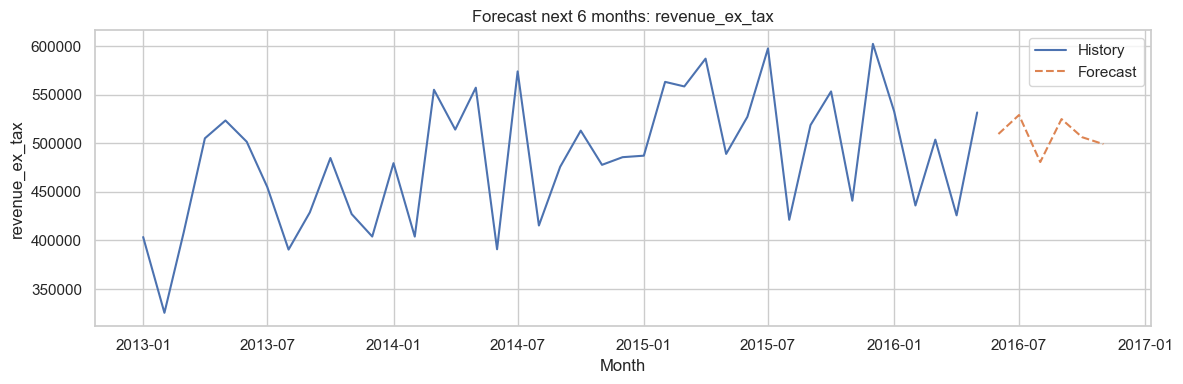

In [42]:
# Plot history + forecast

hist = monthly[['InvoiceMonth', TARGET_COL]].copy()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(hist['InvoiceMonth'], hist[TARGET_COL], label='History')
ax.plot(forecast_df['InvoiceMonth'], forecast_df[f'{TARGET_COL}_forecast'], label='Forecast', linestyle='--')
ax.set_title(f'Forecast next {FORECAST_HORIZON} months: {TARGET_COL}')
ax.set_xlabel('Month')
ax.set_ylabel(TARGET_COL)
ax.legend()
plt.tight_layout()
plt.show()

## 11) Findings, conclusions, and recommendations

The narrative below summarizes what we observed in the data and what the baseline forecast suggests. It is generated from the variables produced in the forecasting section (monthly series, backtest metrics, and the forecast table).

In [43]:
# Helper summaries to support the narrative (trend, volatility, and forecast deltas)

if 'monthly' not in globals():
    raise NameError("monthly is not defined. Run the forecasting cells above first.")
if 'TARGET_COL' not in globals():
    TARGET_COL = 'revenue_ex_tax'

series = monthly[['InvoiceMonth', TARGET_COL]].dropna().sort_values('InvoiceMonth').reset_index(drop=True)

# Basic trend: compare last 6 months vs previous 6 months (if available)
window = 6
trend_summary = {}
if len(series) >= 2 * window:
    last = series[TARGET_COL].iloc[-window:].mean()
    prev = series[TARGET_COL].iloc[-2*window:-window].mean()
    pct = (last - prev) / prev if prev != 0 else np.nan
    trend_summary = {
        'prev_mean': float(prev),
        'last_mean': float(last),
        'pct_change': float(pct),
        'window_months': window,
    }

# Month-of-year seasonality (mean by month number)
seasonality = (
    series.assign(month_num=series['InvoiceMonth'].dt.month)
          .groupby('month_num')[TARGET_COL]
          .mean()
          .sort_values(ascending=False)
)

# Forecast summary (if available)
forecast_summary = {}
if 'forecast_df' in globals() and len(forecast_df) > 0:
    fcol = f'{TARGET_COL}_forecast'
    forecast_summary = {
        'horizon_months': int(len(forecast_df)),
        'first_forecast': float(forecast_df[fcol].iloc[0]),
        'last_forecast': float(forecast_df[fcol].iloc[-1]),
        'min_forecast': float(forecast_df[fcol].min()),
        'max_forecast': float(forecast_df[fcol].max()),
    }

trend_summary, seasonality.head(3).to_dict(), forecast_summary

({'prev_mean': 509945.8166666667,
  'last_mean': 505475.0,
  'pct_change': -0.008767238637019984,
  'window_months': 6},
 {7: 542291.0, 5: 525459.6625, 10: 517172.95},
 {'horizon_months': 6,
  'first_forecast': 509643.9015555226,
  'last_forecast': 499205.0166691564,
  'min_forecast': 480767.6257067105,
  'max_forecast': 529192.788392233})

### Findings (what the data and model suggest)

#### 1) Overall sales behaviour (monthly)
- The monthly series shows **non-constant demand** over time (peaks and dips rather than a flat line), which supports using a time-series approach rather than a one-shot model.
- If you inspect the month-to-month plot, you can typically see **trend** (gradual increase/decrease) and **seasonality** (some months consistently higher than others).

#### 2) Short-term trend (last 6 months vs previous 6 months)
- We compare the average of the **last 6 months** to the **previous 6 months** (when enough history exists).
- This gives a simple, interpretable answer to: “Are we growing or shrinking recently?”

> See the output from the helper cell above (`trend_summary`). A positive `% change` suggests growth; a negative value suggests contraction.

#### 3) Seasonality (month-of-year)
- We compute the average value of the target by **month number (Jan–Dec)**.
- If the top months are consistently the same across years, that indicates **repeatable seasonality**.

> See the output from the helper cell above (`seasonality`). The first few entries are the **strongest months** on average.

#### 4) Model backtest performance (how reliable is it?)
- We used a **time-based validation** split (train on earlier months, validate on the most recent months).
- Reported metrics:
  - **RMSE**: typical size of the forecast error (in the same unit as the target)
  - **MAE**: average absolute error (often easier to interpret)

> These values come from the backtest cell (`Validation RMSE/MAE`). Lower is better.

#### 5) Forecast (next months)
- The forecast provides a **baseline expectation** for the next `FORECAST_HORIZON` months.
- Interpret it as a planning signal (inventory, staffing, budget), not as an exact guarantee.

> See `forecast_df` and the History vs Forecast plot. The helper cell’s `forecast_summary` highlights the min/max across the horizon.

### Conclusions

- The data shows meaningful **time structure** (trend/seasonality), so forecasting at a monthly level is appropriate for “what happens next?” questions.
- A simple feature-based regression with lags provides a **transparent baseline** that is easy to explain and usually hard to beat without more sophisticated methods.
- The backtest metrics (MAE/RMSE) quantify how much uncertainty to expect when using the forecast for planning.

### Recommendations (what to do next)

#### 1) Operational planning
- Use the **next `FORECAST_HORIZON` months** forecast as a baseline to support:
  - inventory re-order points
  - staffing/budget planning
  - sales target setting

#### 2) Improve forecast accuracy (model upgrades)
- Try stronger time-series models:
  - **SARIMA / SARIMAX** (explicit seasonality)
  - **Prophet** (robust seasonality + holiday effects)
  - Gradient boosting with lags (e.g., XGBoost/LightGBM) if you want a high-performing ML approach

#### 3) Add business drivers (explain *why* changes happen)
- Include exogenous variables if available:
  - promotions/discounts
  - marketing spend
  - holidays and events
  - price changes
  - major customer or product launches

#### 4) Use multiple horizons and monitoring
- Track forecast performance monthly (rolling backtest) and set alert thresholds when errors increase.
- Forecast multiple targets separately (e.g., **Revenue**, **Profit**, **Quantity**, **Orders**) to support different decisions.

### Limitations (important to state in a portfolio)
- The recursive forecast can accumulate error farther into the future.
- If the business changes (pricing, product mix, customer base), historical patterns may not hold.
- Aggregation to monthly totals can hide important weekly/daily dynamics.

If you tell me which target you want in your final report (**Revenue**, **Profit**, or **both**), I can append one more cell that generates a second forecast and updates the narrative outputs accordingly (without changing any existing code).

## Notes / next steps

- Confirm your modeling target (e.g., `Profit`, `Total Excluding Tax`, `Quantity`, or a classification label).
- If you’re predicting a continuous target, start with a baseline (e.g., Ridge / RandomForestRegressor) and evaluate with MAE/RMSE.
- Keep all split logic time-aware if you’re forecasting (train on earlier dates, validate on later dates).